# Sensitivity analysis

Solve sensitivity equations to explore / demonstrate how sensitive the solutions are to parameter values

This notebook requires estimates from the SA models, and hence we first have to run the notebooks

* `SequentialApproachFitting.ipynb` for the (primary) CD8 fits
* `SequentialApproachFitCD4.ipynb` for the CD4 fits

In [1]:
from scdynsys import sensitivity
from scdynsys import identifiability as ident

import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import the data

Results from fits are written to the `results` folder by the aforementioned notebooks

In [2]:
data_files = {
    "CD8" : "../results/data_SA_fitting.pkl",
    "CD4" : "../results/data_SA_fitting_CD4.pkl"
}

lineages = ["CD8", "CD4"]

datasets = {}

for lineage in lineages:
    data_file = data_files[lineage]
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    datasets[lineage] = data

t0 = 8.0
celltype_colors = tabcolors

## Select models and get a point estimate from the posterior sample

* for each lineage we fit 4 models, but we focus on just one per lineage
* Summarize the posterior sample into a single point estimate to simulate single trajecties

In [3]:
focal_models = {
    "CD8" : "M4",
    "CD4" : "M3"
}

# parameter dicts with dynamical params (e.g. not sigma)
pardicts_gt_dyn = {}
num_clusters = {}
celltype_names = {}

def get_point_estimate(lineage, model):
    fit_results = datasets[lineage]["fit_results"]
    par_dict, init_guess, data, diag_dict = fit_results[model]
    pd_gt = ident.get_point_est(par_dict, diag_dict, method="median")
    pd_gt_dyn = pd_gt.copy()
    for par in ["sigma", "phi"]:
        pd_gt_dyn.pop(par)
    ## remove eta and u from M3 estimates
    if model == "M3":
        for par in ["u", "eta"]:
            pd_gt_dyn.pop(par)
    return pd_gt_dyn

for lineage in lineages:
    model = focal_models[lineage]
    pd_gt = get_point_estimate(lineage, model)
    pardicts_gt_dyn[lineage] = pd_gt
    num_clusters[lineage] = len(pd_gt["logx0"])
    celltype_names[lineage] = datasets[lineage]["celltype_names"]

## Solve the sensitivity equations

The sensitibity equations are defined in the module `scdydsys.sensitivity`

### Sensitivity equations for the loss rates

We print some shapes of the multidimensional arrays for debugging. The CD8 model has 8 clusters, while the CD4 models has 11. 

In [4]:
t0, tend = 8, 57
ts = np.linspace(t0, tend, 100)
time_ticks = np.linspace(14, 56, 4, dtype=int)

sens_results = {}

sens_solver_dispatch = {
    "M3" : sensitivity.solve_trm_ivp_sens_hom,
    "M4" : sensitivity.solve_trm_ivp_sens
}

for lineage in lineages:
    model = focal_models[lineage]
    pd_gt_dyn = pardicts_gt_dyn[lineage]
    
    sens_result = sens_solver_dispatch[model](ts, t0, **pd_gt_dyn)

    print("shapes of sensitivity results for lineage", lineage)
    print("-" * 50)
    for k, v in sens_result.items():
        print("shape of", k, v.shape)
    sens_results[lineage] = sens_result

shapes of sensitivity results for lineage CD8
--------------------------------------------------
shape of x (8, 100)
shape of ddrho0_x (8, 8, 100)
shape of ddeta_x (8, 8, 100)
shape of ddu_x (8, 100)
shapes of sensitivity results for lineage CD4
--------------------------------------------------
shape of x (11, 100)
shape of ddrho0_x (11, 11, 100)


### Plot the results for the loss rates

Show the cell numbers per population and the sensitivity in $u$.

Notice that $u$ is not defined for model III (CD4 lineage)

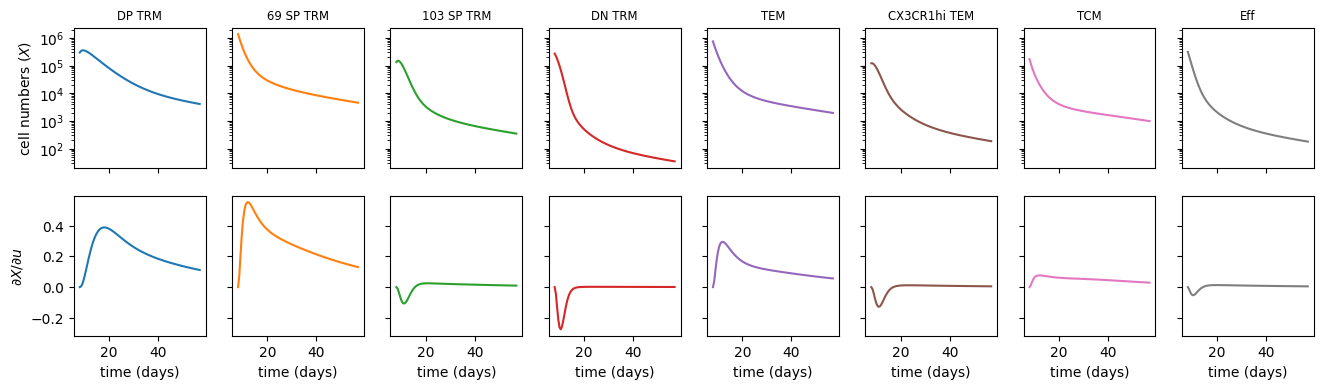

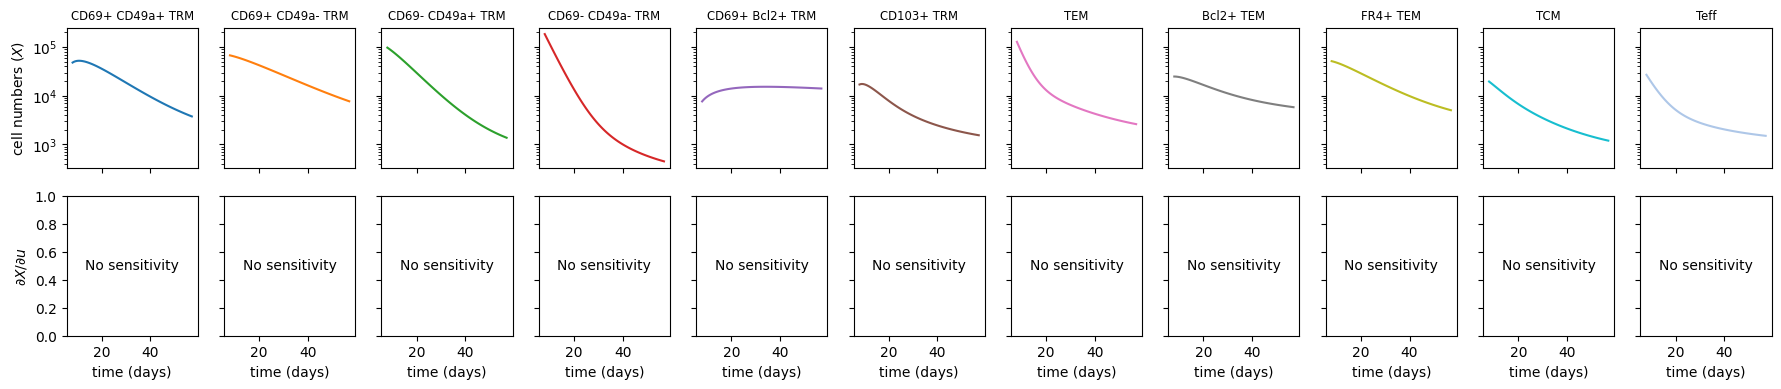

In [5]:
for lineage in lineages:
    num_clus = num_clusters[lineage]
    fig, axs = plt.subplots(2,num_clus, figsize=(2*num_clus,4), sharey='row', sharex=True)
    sens_result = sens_results[lineage]
    count_scaling = datasets[lineage]["count_scaling"]
    ct_names = celltype_names[lineage]
    
    for i in range(num_clus):
        ax = axs[0,i]
        col = celltype_colors[i]
        ax.plot(ts, sens_result["x"][i,:] * count_scaling, color=col)
        ax.set_yscale('log')
        ax.set_title(ct_names[i], fontsize='small')
        
        ax = axs[1,i]
        if "ddu_x" in sens_result:
            ax.plot(ts, sens_result["ddu_x"][i,:], color=col)
        else:
            ax.text(0.5, 0.5, "No sensitivity", ha='center', va='center', transform=ax.transAxes)
        ax.set_xlabel("time (days)")        
    
    axs[0,0].set_ylabel("cell numbers ($X$)")
    axs[1,0].set_ylabel("$\\partial X / \partial u$")

### Show the sensitivity of $X$ w.r.t. $\lambda_E$ and $\lambda_L$

Notice again that $\lambda_E$ and $\lambda_L$ are called $\rho$ and $\eta$ in the python module and stan models.

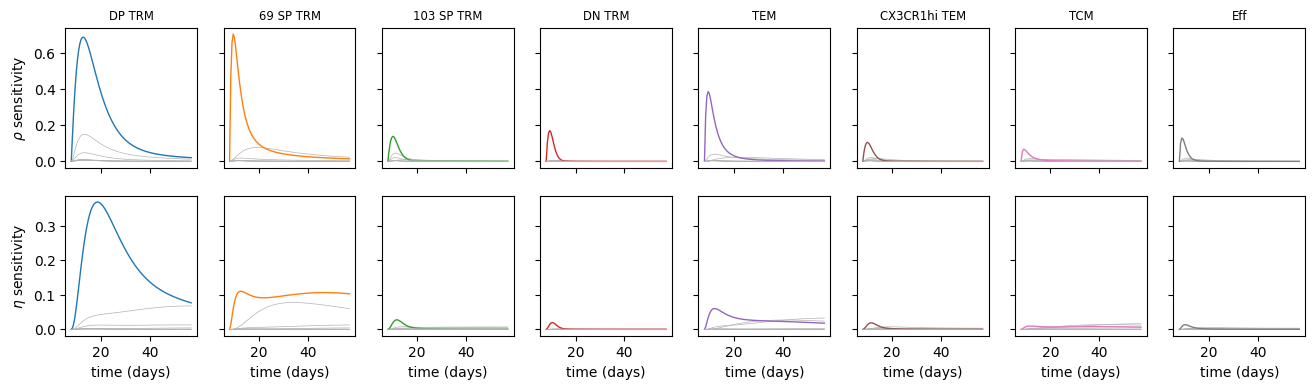

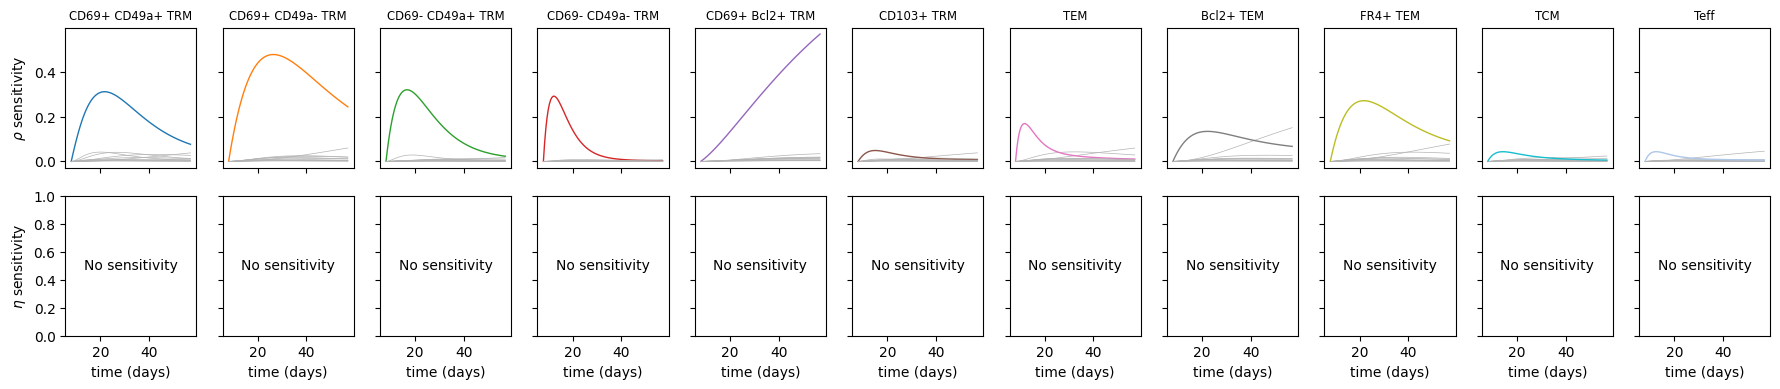

In [6]:
for lineage in lineages:
    num_clus = num_clusters[lineage]
    fig, axs = plt.subplots(2, num_clus, figsize=(2*num_clus,4), sharey='row', sharex=True)
    sens_result = sens_results[lineage]
    count_scaling = datasets[lineage]["count_scaling"]
    ct_names = celltype_names[lineage]

    for i in range(num_clus):
        axs[0,i].set_title(ct_names[i], fontsize='small')

        for j in range(num_clus):
            color = celltype_colors[i] if i == j else '0.7'
            linewidth = 1 if i == j else 0.5
            axs[0,i].plot(ts, sens_result["ddrho0_x"][i,j,:], color=color, linewidth=linewidth)
            if "ddeta_x" in sens_result:
                axs[1,i].plot(ts, sens_result["ddeta_x"][i,j,:], color=color, linewidth=linewidth)
        if "ddeta_x" not in sens_result:
            ax = axs[1,i]
            ax.text(0.5, 0.5, "No sensitivity", ha='center', va='center', transform=ax.transAxes)
        axs[1,i].set_xlabel("time (days)")        

    axs[0,0].set_ylabel("$\\rho$ sensitivity")
    axs[1,0].set_ylabel("$\\eta$ sensitivity")


### Compute and plot Sensitivity of $Y$ and $\pi$

We can also calculate the sensitivity of transfromed variables w.r.t the parameters.

$Y$ is the total population size and $\pi$ is a vector of relative sizes (i.e. $X / Y$).

The module `scdynsys.sensitivity` contains functions to compute transformed sensitivities.

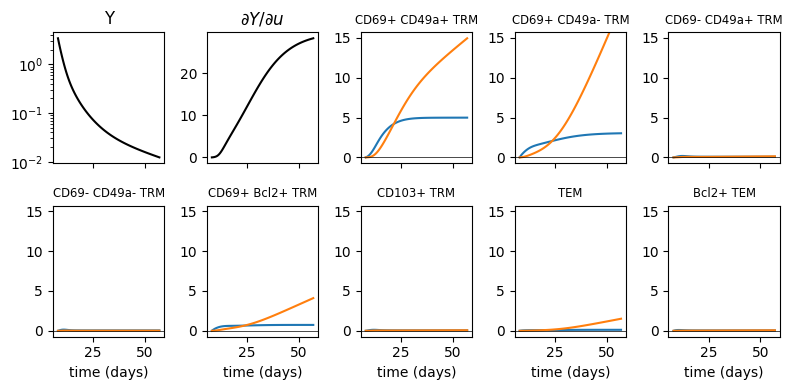

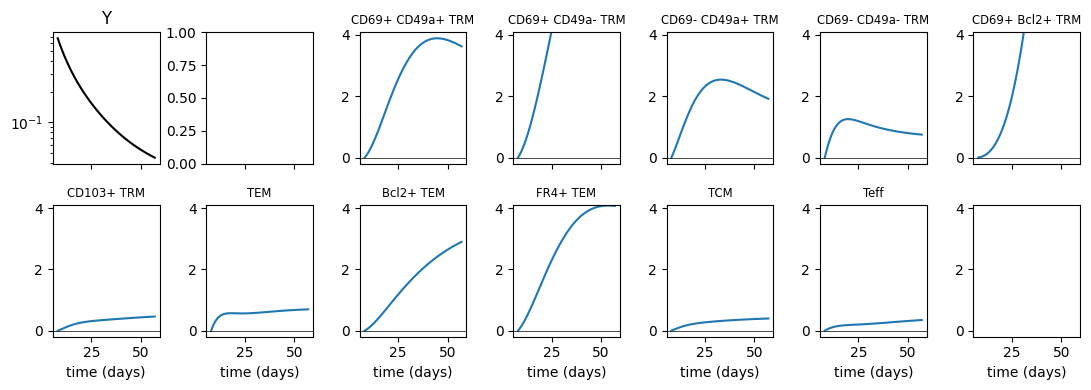

In [7]:
trans_sens_results = {}

sens_trans_dispatch = {
    "M4" : sensitivity.trm_sens_y_pi,
    "M3" : sensitivity.trm_sens_y_pi_hom,
}

for lineage in lineages:
    model = focal_models[lineage]
    trans_sens_result = sens_trans_dispatch[model](sens_results[lineage])
    trans_sens_results[lineage] = trans_sens_result
    num_clus = num_clusters[lineage]

    fig, axs = plt.subplots(2, (num_clus+3) // 2, figsize=(num_clus, 4), sharex=True)

    ax = axs.flat[0]
    ax.plot(ts, trans_sens_result["y"], color='k')
    ax.set_yscale('log')
    ax.set_title("Y")

    if "ddu_logy" in trans_sens_result:
        ax = axs.flat[1]
        ax.plot(ts, trans_sens_result["ddu_logy"], color='k')
        ax.set_title("$\\partial Y / \\partial u$")


    for i in range(num_clus):
        ax = axs.flat[i+2]
        ax.plot(ts, trans_sens_result["ddrho0_logy"][i,:])
        if "ddeta_logy" in trans_sens_result:
            ax.plot(ts, trans_sens_result["ddeta_logy"][i,:])
        ax.axhline(0, color='k', linewidth=0.5)
        ax.set_title(ct_names[i], fontsize='small')
    
    for ax in axs.flat[2:]:
        ax.sharey(axs.flat[2])

    for ax in axs[1,:]:
        ax.set_xlabel("time (days)")

    fig.tight_layout()

### Plot sensitivity of $\pi$ w.r.t $\lambda_E$, $\lambda_L$ and $u$

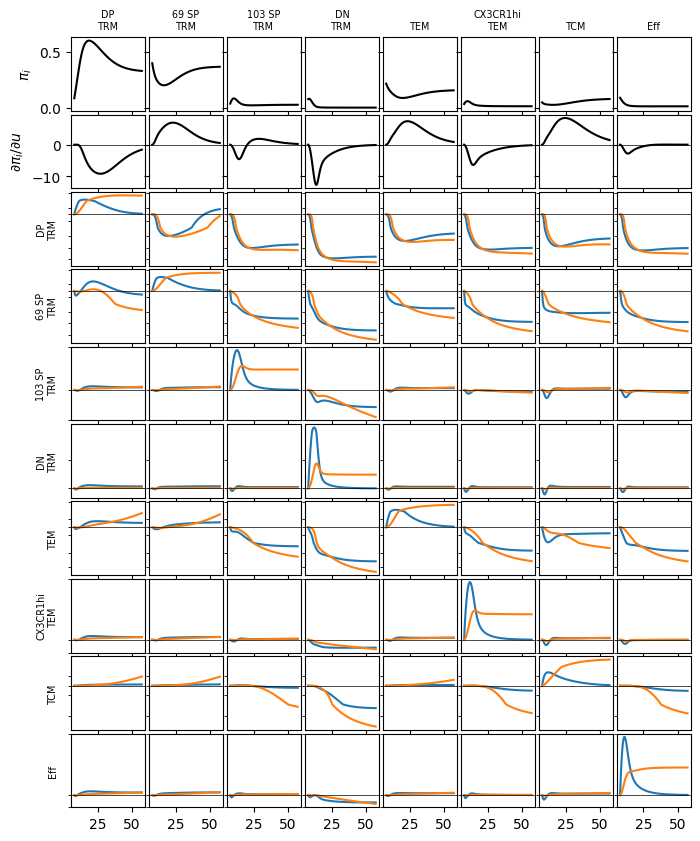

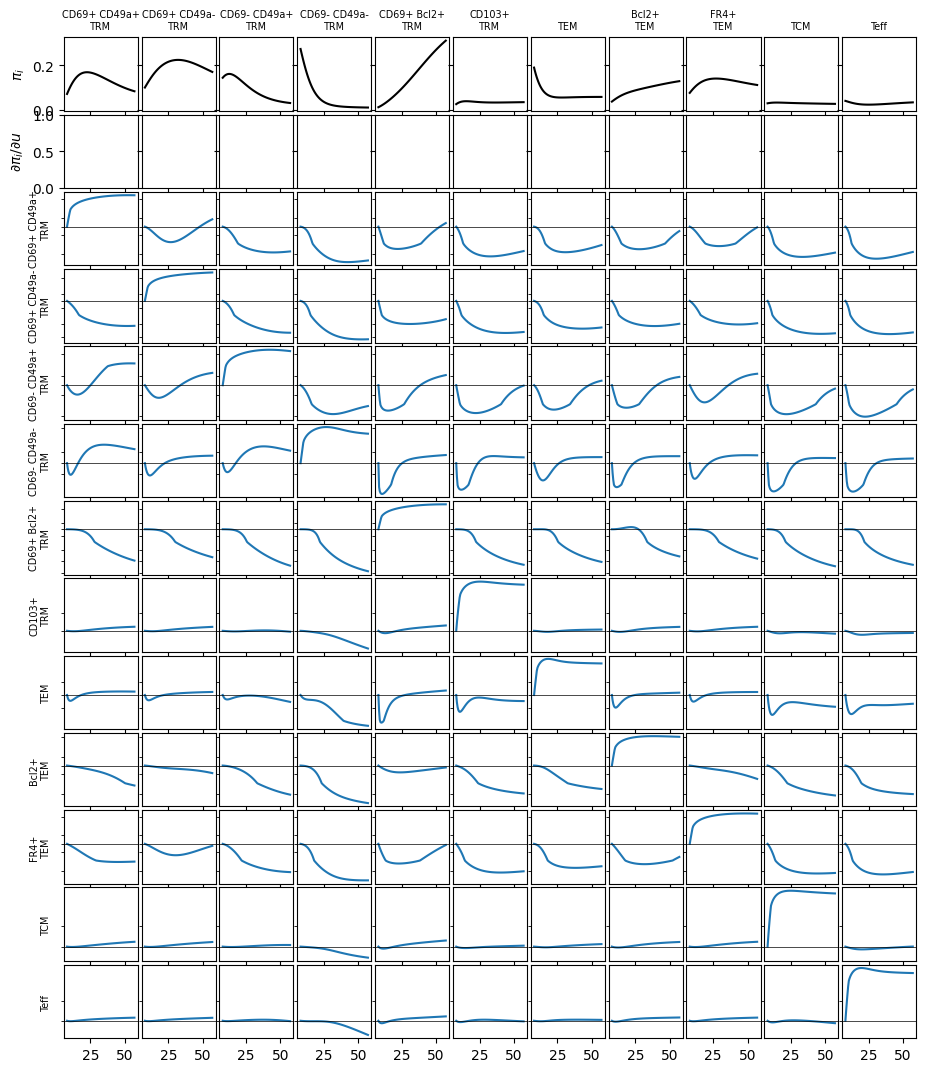

In [8]:
for lineage in lineages:
    model = focal_models[lineage]
    num_clus = num_clusters[lineage]    
    fig, axs = plt.subplots(num_clus + 2, num_clus, figsize=(num_clus,num_clus+2), sharey='row', sharex=True)

    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # get the right transformed sensitivity analysis result
    trans_sens_result = trans_sens_results[lineage]
    ct_names = celltype_names[lineage]
    
    multiline_titles = ["\n".join(ct_names[i].rsplit(" ", 1)) for i in range(num_clus)]

    for i in range(num_clus):
        ax = axs[0,i]
        ax.plot(ts, trans_sens_result["pi"][i,:], color='k')
        
        ax.set_title(multiline_titles[i], fontsize='x-small')
        ax = axs[1,i]
        if "ddu_logitpi" in trans_sens_result:
            ax.plot(ts, trans_sens_result["ddu_logitpi"][i,:], color='k')
        ax.axhline(0, color='k', linewidth=0.5)
        for j in range(num_clus):
            ax = axs[i+2,j]
            ax.plot(ts, trans_sens_result["ddrho_logitpi"][j,i,:])
            if "ddeta_logitpi" in trans_sens_result:
                ax.plot(ts, trans_sens_result["ddeta_logitpi"][j,i,:])
            ax.axhline(0, color='k', linewidth=0.5)
            ax.set_yscale("symlog")
            ax.set_yticks([])
            ax.set_ylabel(multiline_titles[i] if j == 0 else "", fontsize='x-small')
    

    axs[0,0].set_ylabel("$\\pi_i$")
    axs[1,0].set_ylabel("$\\partial\\pi_i / \\partial u$")


## Now compute Q-sensitivity

This is the main focus of the paper: how to trajectories depend on the differentiation matrix elements?

In [9]:
sens_results_Q = {}

sens_solver_Q_dispatch = {
    "M3" : sensitivity.solve_trm_ivp_sens_Q_hom,
    "M4" : sensitivity.solve_trm_ivp_sens_Q,
}

for lineage in lineages:
    print("shapes for", lineage)
    print("-" * 50)

    model = focal_models[lineage]
    pd_gt_dyn = pardicts_gt_dyn[lineage]
    sens_result_Q = sens_solver_Q_dispatch[model](ts, t0, **pd_gt_dyn)

    sens_results_Q[lineage] = sens_result_Q
    
    for k, v in sens_result_Q.items():
        print(k, v.shape)

shapes for CD8
--------------------------------------------------
x (8, 100)
ddQ_x (8, 8, 8, 100)
shapes for CD4
--------------------------------------------------
x (11, 100)
ddQ_x (11, 11, 11, 100)


### Plot sensitivity of the $X$ trajectories on the elements of $Q$

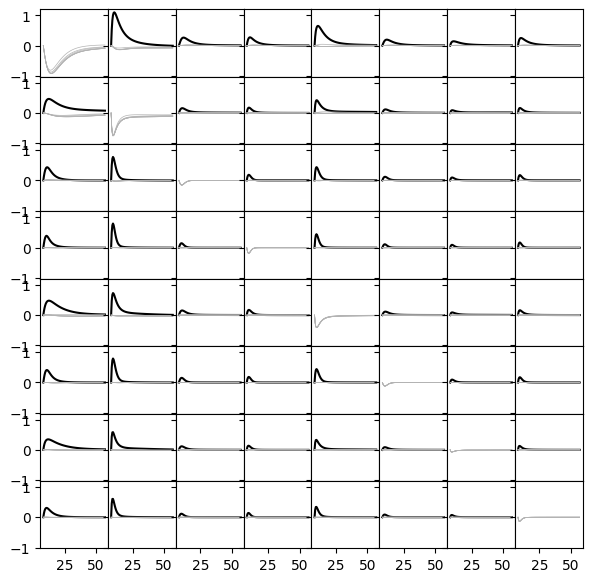

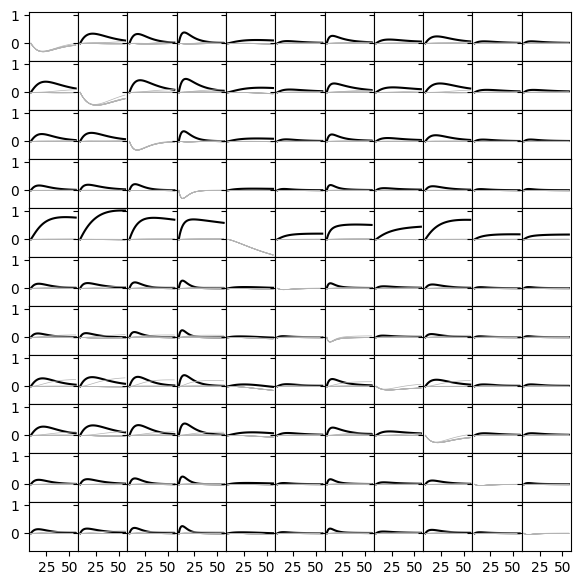

In [10]:
for lineage in lineages:
    model = focal_models[lineage]
    num_clus = num_clusters[lineage]    

    fig, axs = plt.subplots(num_clus, num_clus, figsize=(7,7), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0, hspace=0)

    sens_result_Q = sens_results_Q[lineage]
    
    for k in range(num_clus):
        for i in range(num_clus):
            ax = axs[k,i]
            if k != i:
                ax.plot(ts, sens_result_Q["ddQ_x"][k,k,i,:], color='k') 
                ## should be i -> k for cluster k
            for j in range(num_clus):
                if j == k or i == j:
                    continue
                ax.plot(ts, sens_result_Q["ddQ_x"][k,j,i,:], color='0.7', linewidth=0.5) 
                ## should be i -> j for cluster k


### Transform $Q$-sensitivity: $\pi$, and $Y$

Also includes the logit of $\pi$ and the log of $Y$

In [11]:
trans_sens_results_Q = {}

for lineage in lineages:
    print("shapes for", lineage)
    print("-" * 50)
    sens_result_Q = sens_results_Q[lineage]
    trans_sens_result_Q = sensitivity.trm_sens_y_pi_Q(sens_result_Q)
    trans_sens_results_Q[lineage] = trans_sens_result_Q
    for k, v in trans_sens_result_Q.items():
        print(k, v.shape)

shapes for CD8
--------------------------------------------------
y (100,)
pi (8, 100)
ddQ_y (8, 8, 100)
ddQ_logy (8, 8, 100)
ddQ_pi (8, 8, 8, 100)
ddQ_logitpi (8, 8, 8, 100)
shapes for CD4
--------------------------------------------------
y (100,)
pi (11, 100)
ddQ_y (11, 11, 100)
ddQ_logy (11, 11, 100)
ddQ_pi (11, 11, 11, 100)
ddQ_logitpi (11, 11, 11, 100)


### Plot the trajectories in same order as the Q matrix.

Each panel corresponds with sensitivity w.r.t $Q_{ij}$. 
Trajectories correspond to the different $\pi_k$

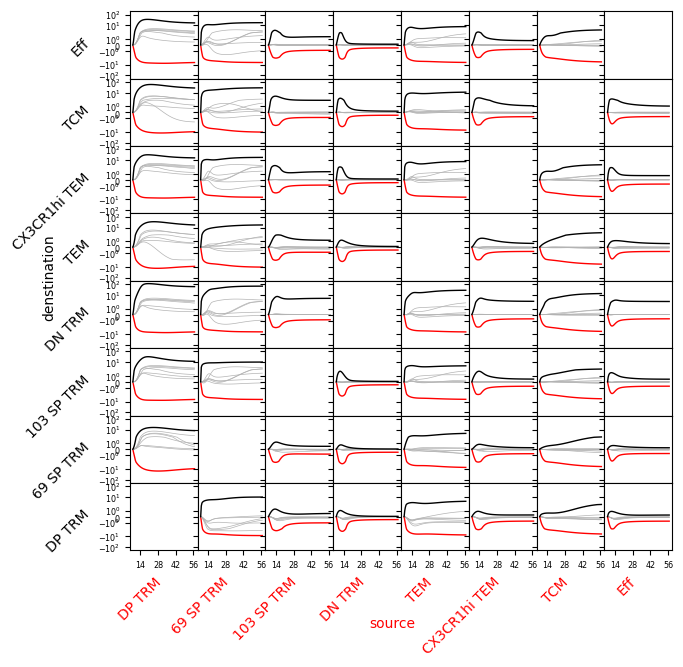

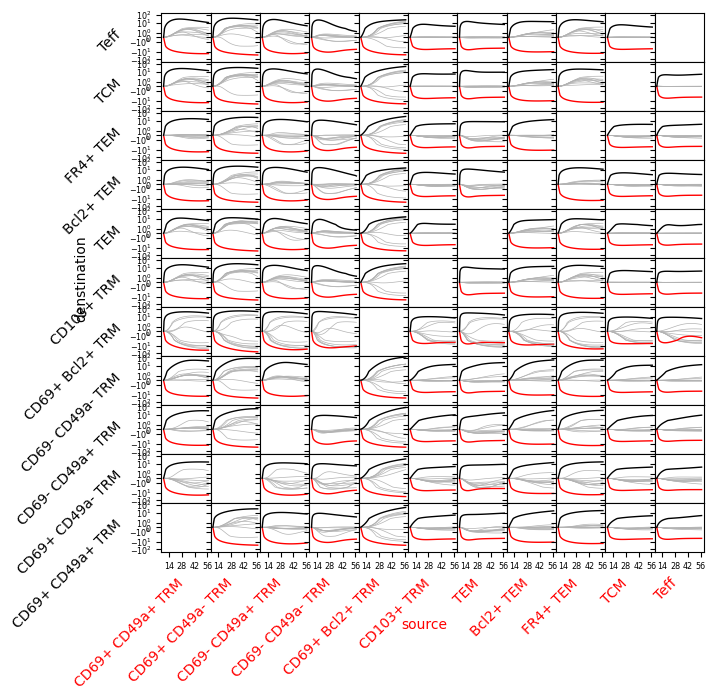

In [12]:
# plot the matrix Qij and the trajectories in each panel

def plot_Q_sens_matrix(lineage):
    model = focal_models[lineage]
    num_clus = num_clusters[lineage]
    ct_names = celltype_names[lineage]
    trans_sens_result_Q = trans_sens_results_Q[lineage]
    
    fig, axs = plt.subplots(num_clus, num_clus, figsize=(7,7), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0, hspace=0)

    for i in range(num_clus):
        for j in range(num_clus):
            ii = num_clus - i - 1
            ax = axs[ii,j]
            if ii == num_clus-1:
                ax.set_xlabel(ct_names[j], rotation=45, ha='right', color='red')
            if j == 0:
                ax.set_ylabel(ct_names[i], rotation=45, ha='right')
            if i == j:
                continue
            for k in range(num_clus):
                xs = trans_sens_result_Q["ddQ_logitpi"][k,i,j,:] ## should be j -> i for cluster k
                if i == k:
                    ax.plot(ts, xs, color='k', linewidth=1, zorder=2) 
                elif k == j:
                    ax.plot(ts, xs, color='r', linewidth=1, zorder=1) 
                else:
                    ax.plot(ts, xs, color='0.7', linewidth=0.5, zorder=1) 

    for ax in axs[:,0]:
        ax.set_yscale('symlog')
        ax.set_ylim(-200, 200)
        plt.setp(ax.get_yticklabels(), fontsize='xx-small')
        #ax.set_yticklabels(yticks, fontsize='xx-small')    
        
    for ax in axs[-1,:]:
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks, fontsize='xx-small')
    
    fig.text(0.5, 0, "source", ha='center', color='red')
    fig.text(0, 0.5, "denstination", rotation=90, va='center')

    return fig, axs


for lineage in lineages:
    fig, axs = plot_Q_sens_matrix(lineage)

### Show sensitivity of $Y$ w.r.t $Q$

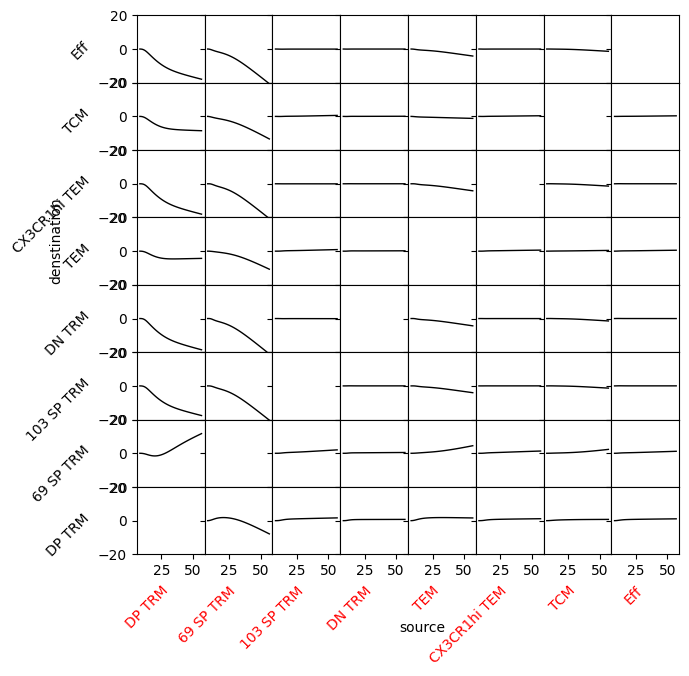

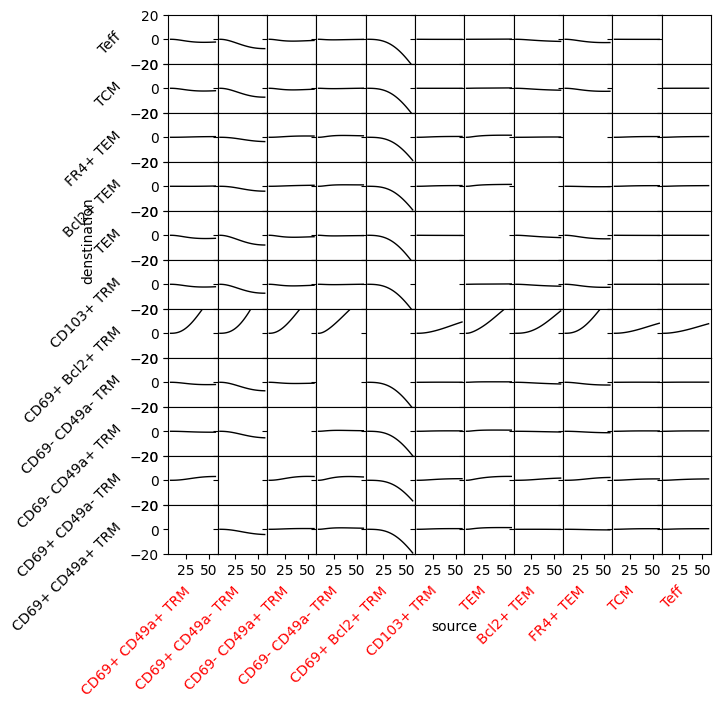

In [13]:
# sensitivity of Y on Qij

print_debug_titles = False

for lineage in lineages:
    model = focal_models[lineage]
    num_clus = num_clusters[lineage]
    ct_names = celltype_names[lineage]
    trans_sens_result_Q = trans_sens_results_Q[lineage]

    fig, axs = plt.subplots(num_clus, num_clus, figsize=(7,7), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0, hspace=0)
        
    for i in range(num_clus):
        for j in range(num_clus):
            ii = num_clus - i - 1
            ax = axs[ii,j]
            if ii == num_clus-1:
                ax.set_xlabel(ct_names[j], rotation=45, ha='right', color='red')
            if j == 0:
                ax.set_ylabel(ct_names[i], rotation=45, ha='right')
            if i == j:
                continue
            if print_debug_titles:
                ax.text(0.95, 0.95, f"{j}>{i}", fontsize='x-small', va='top', ha='right', transform=ax.transAxes)
            ax.plot(ts, trans_sens_result_Q["ddQ_logy"][i,j,:], color='k', linewidth=1) 
            ## should be j -> i for cluster k
    
    axs[0,0].set_ylim(-20,20)
    
    fig.text(0.5, 0, "source")
    fig.text(0, 0.5, "denstination", rotation=90)

## Create a dataset that can be imported in a dedicated Figure notebook

Collect all results calculated above and save a `pickle` in the `results` folder

In [14]:
sens_data_dict = {
    "ts" : ts,
    "time_ticks" : time_ticks,
    "t0" : t0,
    "focal_models" : focal_models,
    "num_clusters" : num_clusters,
    "trans_sens_results_Q" : trans_sens_results_Q,
    "sens_result_Q" : sens_result_Q,
    "celltype_colors" : celltype_colors,
    "celltype_names" : celltype_names,
}

with open("../results/data_figure_sens.pkl", 'wb') as f:
    pickle.dump(sens_data_dict, f)